In [1]:
from Models.GlassBox.ebm.ebm_class import EBM_class
import matplotlib.pyplot as  plt
import pandas as pd
%reload_ext autoreload
%autoreload 2

In [2]:
EBM_parameter = dict(
    learning_rate= [0.005, 0.01, 0.02, 0.03],
    min_samples_leaf=[2, 3, 4, 5],
    max_leaves=[2, 3, 4, 5],
    max_bins=[8, 16],
    interactions=[10, 15, 20],
)
gridsearch_parameters = dict(
    path="./../../../outputs/scores/",
    name="0",
    nDCG_at=15
)

# Grid-search

In [3]:
gs = EBM_class(**gridsearch_parameters)

In [4]:
best_ = gs.grid_search(hyperparameters=EBM_parameter)
gs.save_model(best_[0], name="EBMReg")

Finding the best model: 100%|██████████| 384/384 [03:31<00:00,  1.82it/s, nDCG_15_at=0.99]


# Metric evaluation

In [5]:
best_model = gs.load_model(name="./saved_models/EBMReg")

In [6]:
best_model   

ExplainableBoostingRegressor(feature_names=['fitness_edu_basic',
                                            'fitness_edu_bonus', 'fitness_city',
                                            'fitness_age', 'fitness_exp_basic',
                                            'fitness_exp_bonus',
                                            'fitness_lang_basic',
                                            'fitness_lang_bonus',
                                            'fitness_comp_basic',
                                            'fitness_comp_bonus',
                                            'fitness_know_basic',
                                            'fitness_knowl_bonus'],
                             interactions=15, learning_rate=0.02, max_bins=16,
                             max_leaves=2, max_rounds=8000, n_jobs=-1)

In [7]:
# nDCG on test-set
nDCG_train = gs.eval_model(model=best_model, df=gs.train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_model, df=gs.valid, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_model, df=gs.test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.9604,0.9757,0.9812
Validation,0.9689,0.9854,0.9901
Test,0.9574,0.9787,0.9843


In [8]:
from interpret import show
show(best_model.explain_global())

C:\Users\Andrea\anaconda3\envs\FindHR\Lib\site-packages\interpret\visual\_udash.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  selector.columns[col_idx], selector.iloc[i][col_idx]


<!-- http://127.0.0.1:7001/1932614841360/ -->

# Explanation

In [9]:
best_model = gs.load_model(name="./saved_models/EBMReg")

In [10]:
best_model

ExplainableBoostingRegressor(feature_names=['fitness_edu_basic',
                                            'fitness_edu_bonus', 'fitness_city',
                                            'fitness_age', 'fitness_exp_basic',
                                            'fitness_exp_bonus',
                                            'fitness_lang_basic',
                                            'fitness_lang_bonus',
                                            'fitness_comp_basic',
                                            'fitness_comp_bonus',
                                            'fitness_know_basic',
                                            'fitness_knowl_bonus'],
                             interactions=15, learning_rate=0.02, max_bins=16,
                             max_leaves=2, max_rounds=8000, n_jobs=-1)

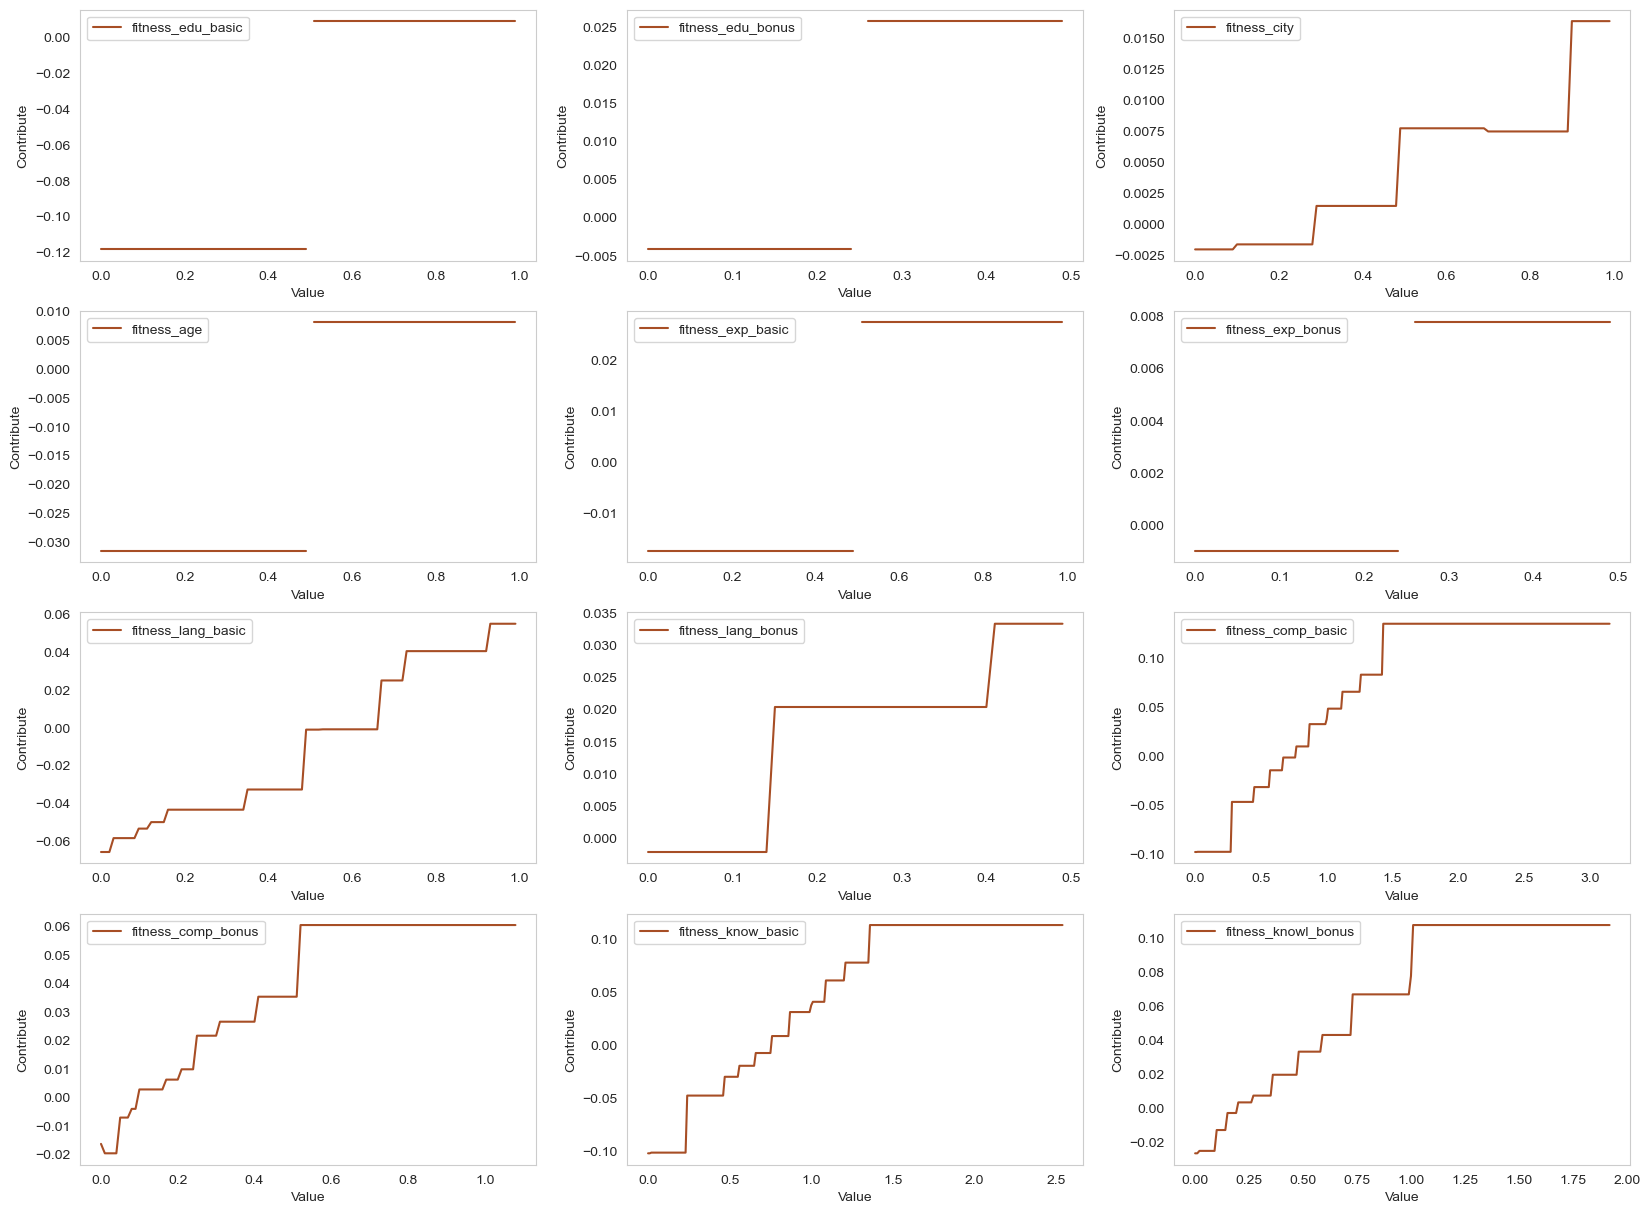

In [11]:
f, axs = plt.subplots(ncols=3,nrows=4,figsize=(20,15))

for i, feature in enumerate(best_model.feature_names):

    x,y = gs.explanation(best_model, i)
    axs[int(i/3)][i%3].set_xlabel("Value")
    axs[int(i/3)][i%3].set_ylabel("Contribute")
    axs[int(i/3)][i%3].grid()
    axs[int(i/3)][i%3].plot(x,y, label=feature, color="#a74e25")
    axs[int(i/3)][i%3].legend()
plt.show(   )